In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stellar-classification-dataset-sdss17/star_classification.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import LabelEncoder


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
oversampler = SMOTE(random_state=1)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold as skf
skfold = skf(n_splits = 4, shuffle = True, random_state = 70)
from sklearn.model_selection import cross_val_score

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [3]:
df= pd.read_csv("/kaggle/input/stellar-classification-dataset-sdss17/star_classification.csv")
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

As we can see, all the features are numerical features except the target variable.

In [5]:
df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


In [6]:
df.columns

Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift',
       'plate', 'MJD', 'fiber_ID'],
      dtype='object')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

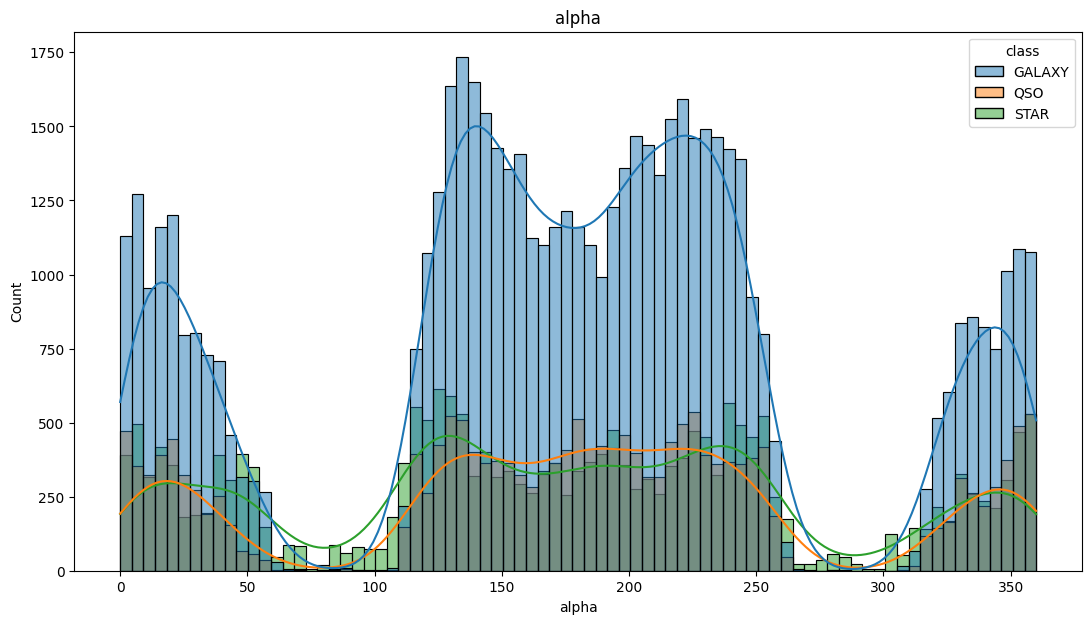

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

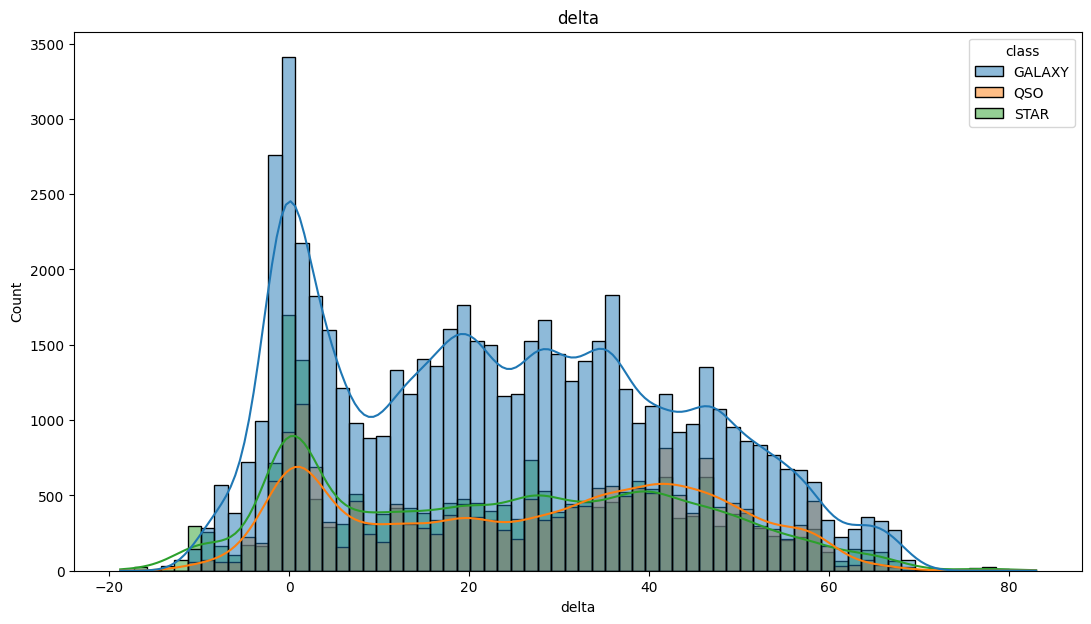

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

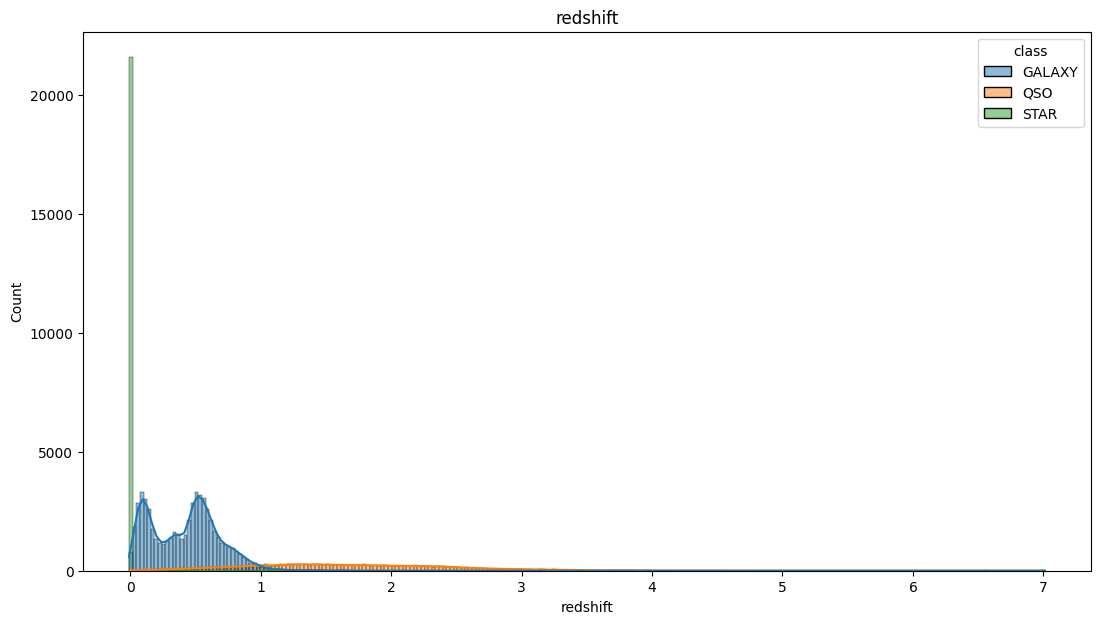

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

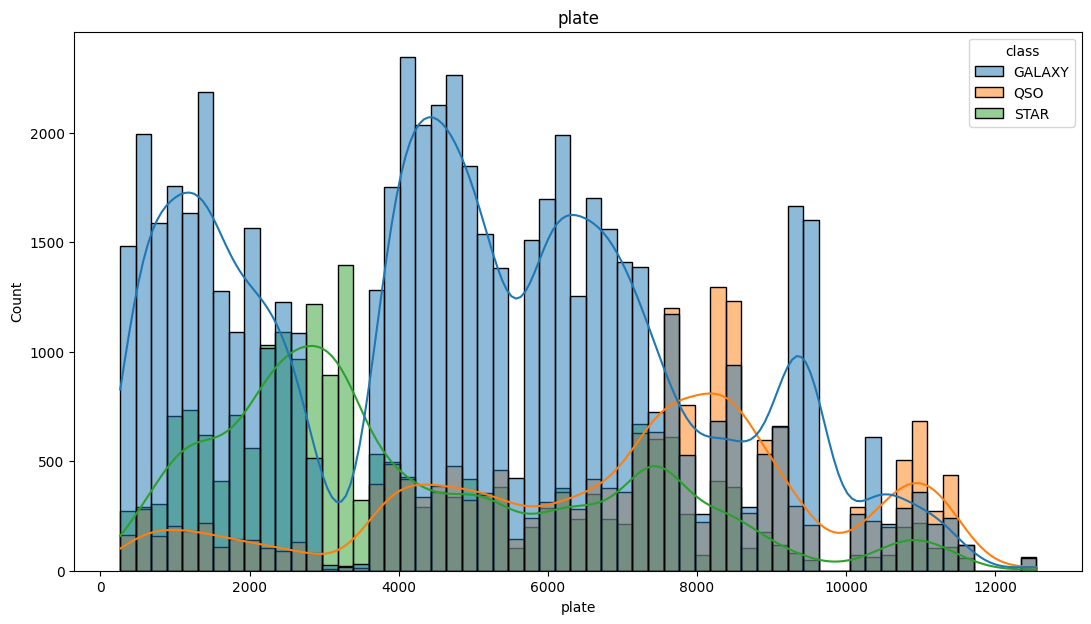

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

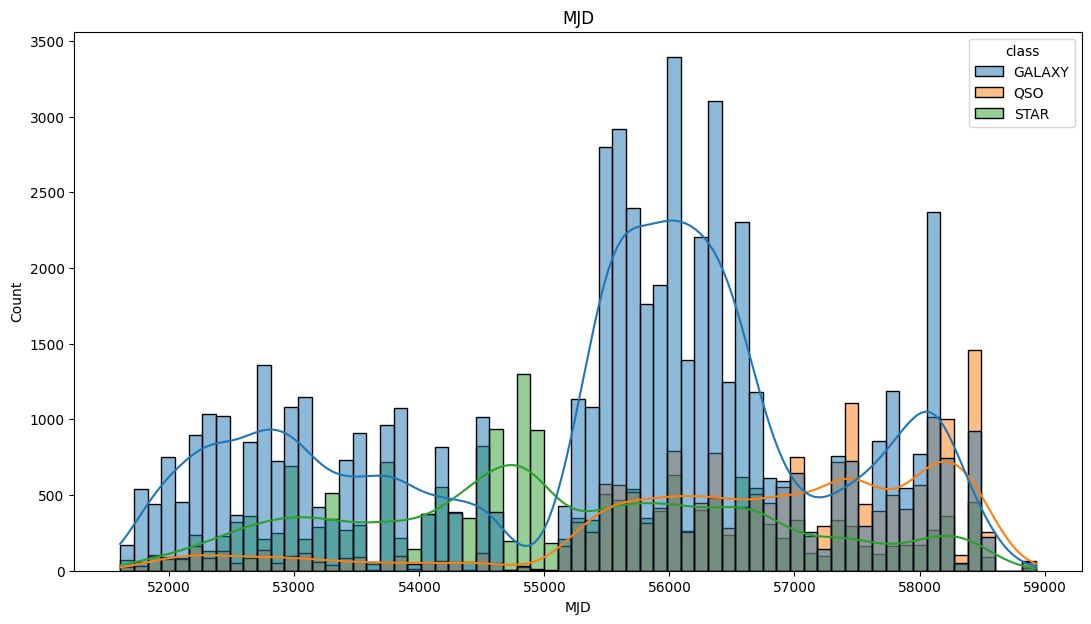

In [7]:
#Data Visualisation
for i in ['alpha', 'delta','redshift', 'plate', 'MJD']:
    plt.figure(figsize=(13,7))
    sns.histplot(data=df, x=i, kde=True, hue="class")
    plt.title(i)
    plt.show()

Data Preprocessing

In [8]:
#Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64


In [9]:
# Count the number of unique classes
num_classes = df['class'].nunique()

# Display the number of classes
print("Number of classes:", num_classes)

Number of classes: 3


In [10]:
df["class"].value_counts()

class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64

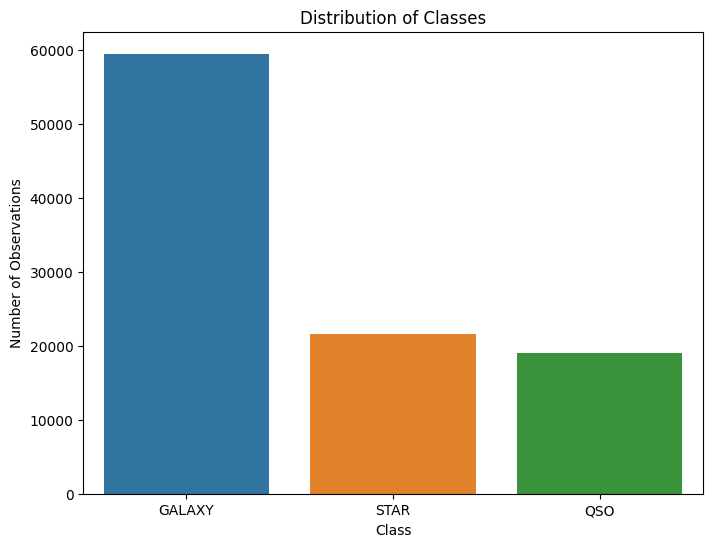

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of observations in each class
class_counts = df['class'].value_counts()

# Plot the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class')
plt.ylabel('Number of Observations')
plt.title('Distribution of Classes')
plt.show()


In [12]:
#Encode the class names
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Convert class names to numerical values
df['class'] = label_encoder.fit_transform(df['class'])

# Display the mapping of class names to numerical values
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Class mapping:", class_mapping)

Class mapping: {'GALAXY': 0, 'QSO': 1, 'STAR': 2}


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  int64  
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(8)


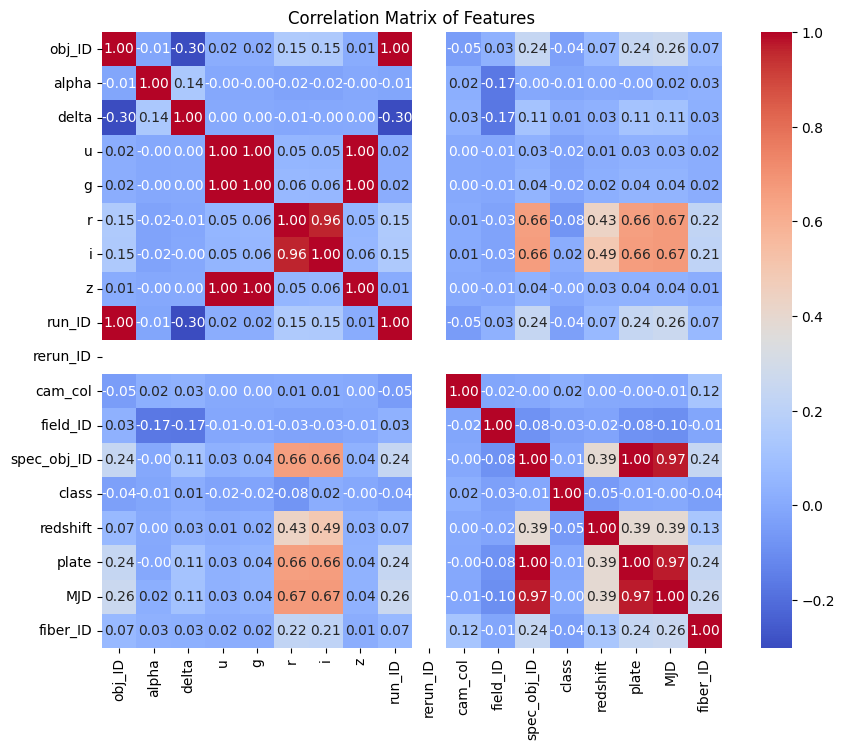

In [14]:
correlation_matrix = df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

In [15]:
#selecting the most important features

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split


# Step 1: Compute Feature Importance
Xfeat = df.drop(['class'], axis=1)  # Features
yfeat = df['class']  # Target variable

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(Xfeat, yfeat, test_size=0.2, random_state=42)

# Train a Random Forest classifier to compute feature importances
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Extract feature importances and select features with importance > threshold
feature_importances = rf.feature_importances_
threshold = 0.01  # Adjust threshold as needed
selected_features = Xfeat.columns[feature_importances > threshold]

# Step 2: Analyze Correlation
correlation_matrix = df[selected_features].corr()
# Then, identify and drop highly correlated features if necessary

# Step 3: Check Variance
variance_threshold = 0.01  # Adjust threshold as needed
low_variance_features = Xfeat.columns[Xfeat.var() < variance_threshold]
selected_features = selected_features.difference(low_variance_features)

# Drop irrelevant features from the dataset
star_data = df[selected_features]

# Check the shape of the final dataset
print("Shape of final dataset after feature selection:", star_data.shape)

Shape of final dataset after feature selection: (100000, 9)


In [16]:
star_data.head()

,MJD,g,i,plate,r,redshift,spec_obj_ID,u,z
0,56354,22.27530,19.16573,5812,20.39501,0.634794,6.543777e+18,23.87882,18.79371
1,58158,22.83188,21.16812,10445,22.58444,0.779136,1.176014e+19,24.77759,21.61427
2,55592,22.66389,19.34857,4576,20.60976,0.644195,5.152200e+18,25.26307,18.94827
3,58039,23.77656,20.50454,9149,21.61162,0.932346,1.030107e+19,22.13682,19.25010
4,56187,17.58028,15.97711,6121,16.49747,0.116123,6.891865e+18,19.43718,15.54461


In [17]:
star_data.columns

Index(['MJD', 'g', 'i', 'plate', 'r', 'redshift', 'spec_obj_ID', 'u', 'z'], dtype='object')

In [18]:
#Data Scaling
scaler = StandardScaler()

# Fit the scaler to your feature dataset
scaler.fit(star_data)

# Transform the features using the scaler
scaled_star_data = scaler.transform(star_data)

In [19]:
scaled_star_df = pd.DataFrame(scaled_star_data, columns=star_data.columns)

In [20]:
scaled_star_df.head()

,MJD,g,i,plate,r,redshift,spec_obj_ID,u,z
0,0.423203,0.054926,0.046007,0.228633,0.403962,0.079557,0.228609,0.059755,0.003937
1,1.420729,0.072456,1.185097,1.797924,1.584406,0.277096,1.797912,0.088045,0.092835
2,0.001854,0.067165,0.150019,-0.190025,0.519745,0.092423,-0.190037,0.103327,0.008808
3,1.354927,0.102210,0.807610,1.358942,1.059904,0.486770,1.358962,0.004921,0.018321
4,0.330860,-0.092948,-1.767887,0.333297,-1.697421,-0.630267,0.333328,-0.080055,-0.098468


In [21]:
#Train-test split
X=scaled_star_df
y=df["class"]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
#Dealing with imbalanced dataset
# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [23]:
X_train_resampled.shape

(142755, 9)

<Axes: xlabel='class'>

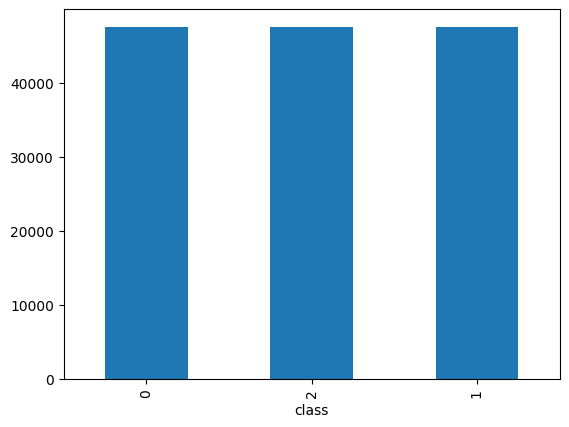

In [24]:
pd.Series(y_train_resampled).value_counts().plot.bar()

In [25]:
#Machine Learning Models

#Decision Tree

from sklearn.metrics import classification_report, confusion_matrix

# Instantiate model
decision_tree = DecisionTreeClassifier()

# Train model
decision_tree.fit(X_train_resampled, y_train_resampled)

# Evaluate model on test set
y_pred_decision_tree = decision_tree.predict(X_test)

# Print evaluation metrics
print("Decision Tree:")
print(classification_report(y_test, y_pred_decision_tree))
print(confusion_matrix(y_test, y_pred_decision_tree))


Decision Tree:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     11860
           1       0.89      0.93      0.91      3797
           2       0.99      1.00      1.00      4343

    accuracy                           0.96     20000
   macro avg       0.95      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000

[[11399   439    22]
 [  258  3538     1]
 [   17     0  4326]]


In [26]:
#Random Forrest

from sklearn.ensemble import RandomForestClassifier

# Instantiate model
random_forest = RandomForestClassifier()

# Train model
random_forest.fit(X_train_resampled, y_train_resampled)

# Evaluate model on test set
y_pred_random_forest = random_forest.predict(X_test)

# Print evaluation metrics
print("Random Forest:")
print(classification_report(y_test, y_pred_random_forest))
print(confusion_matrix(y_test, y_pred_random_forest))

Random Forest:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11860
           1       0.95      0.94      0.94      3797
           2       0.99      1.00      1.00      4343

    accuracy                           0.98     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.98      0.98      0.98     20000

[[11629   204    27]
 [  220  3576     1]
 [    2     0  4341]]


In [27]:
from sklearn.svm import SVC

# Instantiate model
svm = SVC()

# Train model
svm.fit(X_train_resampled, y_train_resampled)

# Evaluate model on test set
y_pred_svm = svm.predict(X_test)

# Print evaluation metrics
print("SVM:")
print(classification_report(y_test, y_pred_svm))
print(confusion_matrix(y_test, y_pred_svm))

SVM:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     11860
           1       0.93      0.93      0.93      3797
           2       0.93      1.00      0.96      4343

    accuracy                           0.96     20000
   macro avg       0.95      0.96      0.95     20000
weighted avg       0.96      0.96      0.96     20000

[[11283   256   321]
 [  266  3526     5]
 [    0     0  4343]]


In [28]:
from sklearn.linear_model import LogisticRegression

# Instantiate model
logistic_regression = LogisticRegression()

# Train model
logistic_regression.fit(X_train_resampled, y_train_resampled)

# Evaluate model on test set
y_pred_logistic_regression = logistic_regression.predict(X_test)

# Print evaluation metrics
print("Logistic Regression:")
print(classification_report(y_test, y_pred_logistic_regression))
print(confusion_matrix(y_test, y_pred_logistic_regression))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     11860
           1       0.88      0.92      0.90      3797
           2       0.92      1.00      0.96      4343

    accuracy                           0.94     20000
   macro avg       0.92      0.95      0.94     20000
weighted avg       0.94      0.94      0.94     20000

[[11018   491   351]
 [  299  3495     3]
 [    3     7  4333]]


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
from sklearn.ensemble import GradientBoostingClassifier

# Instantiate model
gradient_boosting = GradientBoostingClassifier()

# Train model
gradient_boosting.fit(X_train_resampled, y_train_resampled)

# Evaluate model on test set
y_pred_gradient_boosting = gradient_boosting.predict(X_test)

# Print evaluation metrics
print("Gradient Boosting:")
print(classification_report(y_test, y_pred_gradient_boosting))
print(confusion_matrix(y_test, y_pred_gradient_boosting))

Gradient Boosting:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     11860
           1       0.93      0.94      0.93      3797
           2       0.98      1.00      0.99      4343

    accuracy                           0.97     20000
   macro avg       0.96      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000

[[11485   283    92]
 [  226  3570     1]
 [    2     0  4341]]


In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Define a function to print evaluation metrics
def print_metrics(model_name, y_true, y_pred):
    print(model_name)
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='weighted'))
    print("Recall:", recall_score(y_true, y_pred, average='weighted'))
    print("F1-score:", f1_score(y_true, y_pred, average='weighted'))
    # If binary classification, you can also calculate ROC AUC score
    # print("ROC AUC score:", roc_auc_score(y_true, y_pred))

# Evaluate each model and print metrics
models = [
    ("Decision Tree", y_pred_decision_tree),
    ("Random Forest", y_pred_random_forest),
    ("SVM", y_pred_svm),
    ("Logistic Regression", y_pred_logistic_regression),
    ("Gradient Boosting", y_pred_gradient_boosting)
]

for model_name, y_pred in models:
    print_metrics(model_name, y_test, y_pred)
    print()


Decision Tree
Accuracy: 0.96315
Precision: 0.9639259724000414
Recall: 0.96315
F1-score: 0.9634093057522402

Random Forest
Accuracy: 0.9773
Precision: 0.9772540287417001
Recall: 0.9773
F1-score: 0.9772741010637769

SVM
Accuracy: 0.9576
Precision: 0.958329183366353
Recall: 0.9576
F1-score: 0.9575887510107921

Logistic Regression
Accuracy: 0.9423
Precision: 0.9441010034657126
Recall: 0.9423
F1-score: 0.9424836118885778

Gradient Boosting
Accuracy: 0.9698
Precision: 0.9699580191459145
Recall: 0.9698
F1-score: 0.9698239504359608

